# Pneumonia Classification

**Data Scientist**: Brian Keating, Anhduy (Andy) Nguyen

**Date**: June 26,2022

#### Stake Holder

- UNICEF(United Nations International Children's Emergency Fund) and Save the Children

### Business Understanding

The UNICEF and Save the Children join task forced approached us with the knowledge that over 800,000 children under the age of 5 die of pneumonia every year. Pneumonia is a form of acute respiratory infection that affects the lungs.  It affects children and families everywhere, but is most prevalent cause of death in South Asia and sub-Saharan Africa.  This is because pneumonia is known as a disease of poverty where in these location the hospital is understaffed, the facilities are underdeveloped, and the families can't afford to get treatment.

### Business Problem

The task at hand is to build an image classification model/system utilizing chest x-rays to correctly classify patients infected with pneumonia vs patient who have healthy lungs.  This will lower the burden on doctors and allow nurses and those with the skill set to retrieve x-ray images to do a secondary diagnosis of pneumonia on the patient and seek out a doctor for a second opinion.

### Data Understanding

Our data was retrieved from Kaggle.com, but originated from Mendeley Data. Mendely Data(https://data.mendeley.com/datasets/rscbjbr9sj/3), Kaggle Data(https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).  There are around 5000 plus images of patients that are split into training, testing, and validation sets.  Within in those sits patients are further split into Non-Pneumonia and Pneumonia classifications.  The images belong to children between the ages of 0-5 gathered from the Guangzhou Women and Children's Medical Center.

### Import Libraries

In [1]:
# Importing Libararies that will be used 

import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore')


from numpy.random import seed
seed(42)

import os
import tqdm
from os import walk
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, plot_roc_curve, \
make_scorer, recall_score, precision_score, f1_score
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau

### 1. Data Preparation

The data was already neatly split into Training, Testing, and Validation sets and further split into Pneumonia and Non Pneumonia patients.  There was minimal data preparation to do on this particular data set.

#### 1.A Pulling in data

In [2]:
# Pulling in Data

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
# get all the data in the directory xray/test (624 images), and reshape them
test = get_training_data('Data/chest_xray/chest_xray/test')

# get all the data in the directory xray/val (16 images), and reshape them
val = get_training_data('Data/chest_xray/chest_xray/val')

# get all the data in the directory xray/train (5216 images), and reshape them
train = get_training_data('Data/chest_xray/chest_xray/train')

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [4]:
# Splitting the images into the images itself and its classification

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [5]:
#Normalize the data
x_train = np.array(x_train) / 253
x_val = np.array(x_val) / 253
x_test = np.array(x_test) / 253

In [6]:
#reshaping data for logistic regression
train_img = x_train.reshape(x_train.shape[0], -1)
test_img = x_test.reshape(x_test.shape[0], -1)
val_img = x_val.reshape(x_val.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)



(5216, 22500)
(624, 22500)
(16, 22500)


In [7]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [8]:
# Showing shape of images

m_train = x_train.shape[0]
num_px = x_train.shape[1]
m_test = x_test.shape[0]
m_val = x_val.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(x_train.shape))
print ("train_labels shape: " + str(y_train.shape))
print ("test_images shape: " + str(x_test.shape))
print ("test_labels shape: " + str(y_test.shape))
print ("val_images shape: " + str(x_val.shape))
print ("val_labels shape: " + str(y_val.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 150, 150, 1)
train_labels shape: (5216,)
test_images shape: (624, 150, 150, 1)
test_labels shape: (624,)
val_images shape: (16, 150, 150, 1)
val_labels shape: (16,)


As shown above there are 624 images in the test set, 16 images in the validation set, and 5216 images in the training set.

- Due to the limitations of the amount of data we have recieved and because images classification requires a lot of data to work properly we will run data augmentation on the images, by shifting images, rotating images, and flipping images.

#### 1.B Data Augmentation

In [9]:
#Augmenting the data in different ways

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
# Reshaping data to run models

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(5216, 150, 150, 1)
(5216,)
(16, 150, 150, 1)
(16,)
(624, 150, 150, 1)
(624,)


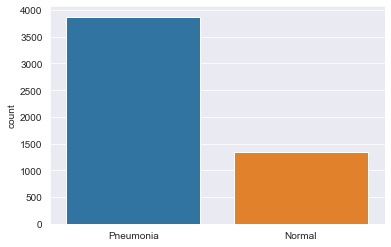

<Figure size 432x288 with 0 Axes>

In [11]:
# Showing the difference between Non Pneumonia Images and Pneumonia Images

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style("darkgrid")
sns.countplot(l)
plt.show()

plt.savefig('img/PneumoniavsNonPneumonia.png', bbox_inches = "tight")

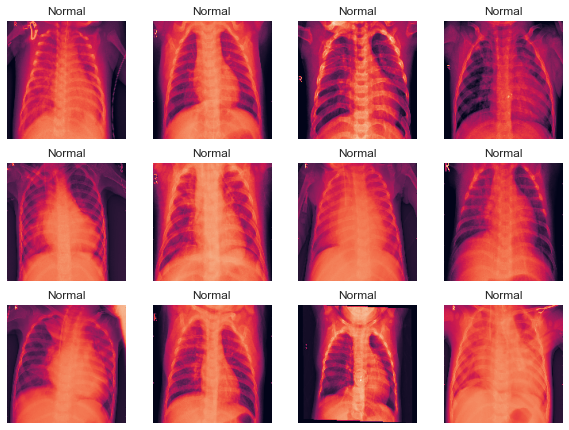

In [12]:
# Showing Image examples

plt.figure(figsize = (10,10))
number = 12
for i in range (number):
    ax = plt.subplot(4,4, i +1)
    plt.imshow(x_train[i])
    if y_train[i] == 0:
        plt.title("Normal")
    else:
        plt.title("Pneumonia")
    plt.axis('off')
    plt.savefig('img/PneumoniaImages.png', bbox_inches = "tight")

### Data Modeling

#### 1.A Logistic Regression

We first start off with a Logistic Regression to see if we can achieve a good accuracy and recall score using it classification abilities.  Then we move on to CNN because it is a commonly used model for image classification.

0.7387820512820513
0.3247863247863248


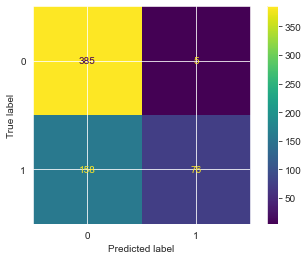

In [13]:
# Baseline Logistic Regression

lr = LogisticRegression(random_state = 42)

lr.fit(train_img, y_train)

print(lr.score(test_img, y_test))

y_pred = lr.predict(test_img)

print(recall_score(y_test, y_pred))

plot_confusion_matrix(lr, test_img, y_test)
plt.show()

 - The accuracy score although better than random chance isn't that great witha score of .73 and the recall score is very low with a .32,  it shows on the confusion matrix when using a baseline Logistic Regression that you won't get a very good model.

#### 1.B CNN

In [14]:
# Baseline Model

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(22500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='sgd',
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

histoire = model.fit(train_img,
                    y_train,
                    epochs = 50,
                    batch_size = 32,
                    validation_data=(val_img,y_val))

print(f"\nTraining Score: {model.evaluate(train_img, y_train)}")
print(f"\nTest Score: {model.evaluate(test_img, y_test)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                450020    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 450,213
Trainable params: 450,213
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 1s 4ms/step - loss: 0.4691 - accuracy: 0.7636 - recall: 0.1178 - val_loss: 1.0466 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 2/50
163/163 [==============================] - 0s 2ms/ste

163/163 [==============================] - 0s 3ms/step - loss: 0.0931 - accuracy: 0.9666 - recall: 0.9269 - val_loss: 0.3819 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 42/50
163/163 [==============================] - 0s 2ms/step - loss: 0.0916 - accuracy: 0.9643 - recall: 0.9217 - val_loss: 0.3315 - val_accuracy: 0.8750 - val_recall: 0.7500
Epoch 43/50
163/163 [==============================] - 0s 2ms/step - loss: 0.0871 - accuracy: 0.9674 - recall: 0.9299 - val_loss: 0.2627 - val_accuracy: 0.8750 - val_recall: 0.7500
Epoch 44/50
163/163 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.9682 - recall: 0.9299 - val_loss: 0.3082 - val_accuracy: 0.8750 - val_recall: 0.7500
Epoch 45/50
163/163 [==============================] - 0s 3ms/step - loss: 0.0862 - accuracy: 0.9676 - recall: 0.9314 - val_loss: 0.3887 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 46/50
163/163 [==============================] - 0s 3ms/step - loss: 0.1020 - accuracy: 0.9599 - reca

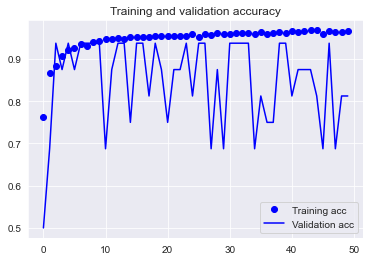

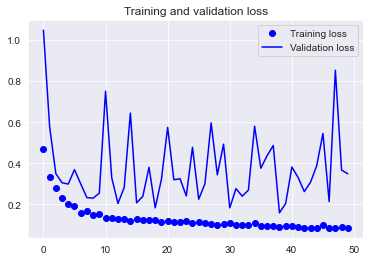

<Figure size 432x288 with 0 Axes>

In [15]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('img/BaseModel.png', bbox_inches = "tight")

 - We see our base line model scored .72 for accuracy and .28 for recall similar to our logistic regression, leds add Conv2d and MaxPool2D

In [16]:
# Conv2d and MaxPool2D Model

model = models.Sequential()
model.add(layers.Conv2D(32 , (3,3), strides = 1, activation='relu', input_shape=(150,150,1)))
model.add(layers.MaxPool2D((2,2), strides = 2))


model.add(layers.Conv2D(64, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))


model.add(layers.Conv2D(64, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))


model.add(layers.Conv2D(128, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))

model.add(layers.Conv2D(256, (3,3), strides = 1, activation='relu'))
model.add(layers.MaxPool2D((2,2), strides = 2))

model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))


model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='sgd',
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

histoire = model.fit(x_train,
                    y_train,
                    epochs = 20,
                    steps_per_epoch= 80,
                    batch_size = 32,
                    validation_data=(x_val,y_val))

print(f"\nTraining Score: {model.evaluate(x_train, y_train)}")
print(f"\nTest Score: {model.evaluate(x_test, y_test)}")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

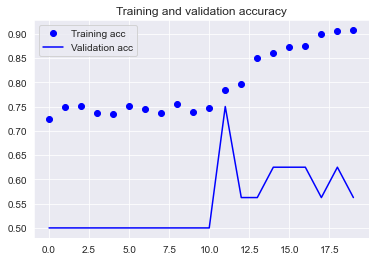

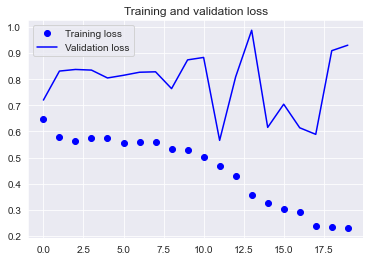

<Figure size 432x288 with 0 Axes>

In [17]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('img/2ndModel.png', bbox_inches = "tight")

- Looks like there was a minor increase in accuracy and a major increase in recall, Lets change the optimizer, add batch normilization, and add padding of same

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32 , (3,3), strides = 1, padding = 'same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(128, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Conv2D(256, (3,3), strides = 1, padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))


model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer= "rmsprop",
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

histoire = model.fit(x_train,
                    y_train,
                    epochs = 20,
                    steps_per_epoch = 80,
                    batch_size = 32,
                    validation_data=(x_val,y_val))

print(f"\nTraining Score: {model.evaluate(x_train, y_train)}")
print(f"\nTest Score: {model.evaluate(x_test, y_test)}")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 38, 38, 64)       

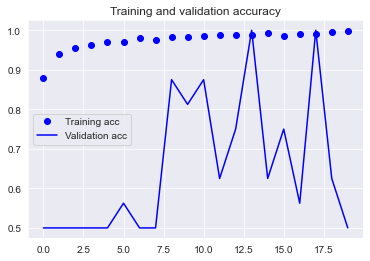

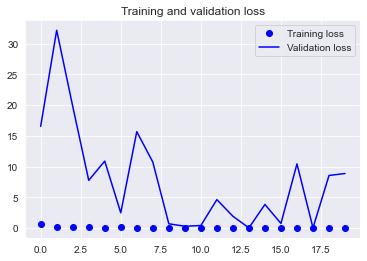

<Figure size 432x288 with 0 Axes>

In [19]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('img/3rdModel.png', bbox_inches = "tight")

- It looks like the Data is overfitting for the training lets reduce the overfitting by introducing dropout.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32 , (3,3), strides = 1, padding = 'same',  
                        activation='relu',  
                        input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same',  
                        activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same',  
                        activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(128, (3,3), strides = 1, padding = 'same',  
                        activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Conv2D(256, (3,3), strides = 1, padding = 'same', 
                        activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer= "rmsprop",
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

histoire = model.fit(x_train,
                    y_train,
                    epochs = 12,
                    batch_size = 32,
                    validation_data=(x_val,y_val))

print(f"\nTraining Score: {model.evaluate(x_train, y_train)}")
print(f"\nTest Score: {model.evaluate(x_test, y_test)}")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 38, 38, 64)       

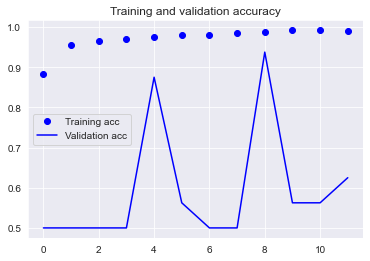

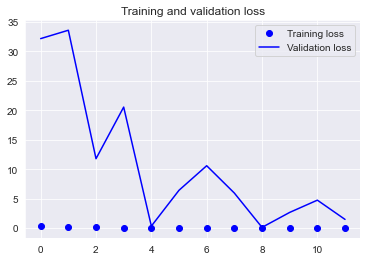

<Figure size 432x288 with 0 Axes>

In [21]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('img/4thModel.png', bbox_inches = "tight")

- Let add a Learning rate reducer to account for overfitting

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32 , (3,3), strides = 1, padding = 'same',  
                        activation='relu',  
                        input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same',  
                        activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(64, (3,3), strides = 1, padding = 'same',  
                        activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(layers.Conv2D(128, (3,3), strides = 1, padding = 'same',  
                        activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Conv2D(256, (3,3), strides = 1, padding = 'same', 
                        activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.2))


model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer= "rmsprop",
             loss = 'binary_crossentropy',
             metrics =  ['accuracy', tf.keras.metrics.Recall()])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.3, min_lr=0.000001)

histoire = model.fit(model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                               epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,
                               callbacks = [learning_rate_reduction]))



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 38, 38, 64)       

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.keras.callbacks.History'>, <class 'NoneType'>

In [23]:
print(f"\nTraining Score: {model.evaluate(x_train, y_train)}")
print(f"\nTest Score: {model.evaluate(x_test, y_test)}")

163/163 [==============================] - 16s 98ms/step - loss: 0.3092 - accuracy: 0.8913 - recall_4: 0.9963

Training Score: [0.3092022240161896, 0.8912960290908813, 0.9962714314460754]
20/20 [==============================] - 2s 90ms/step - loss: 0.3994 - accuracy: 0.9038 - recall_4: 0.8761

Test Score: [0.3993529677391052, 0.9038461446762085, 0.8760683536529541]


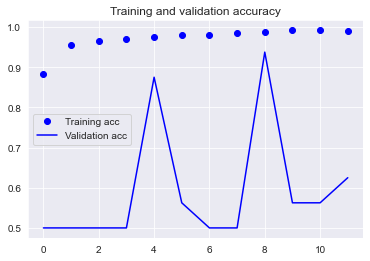

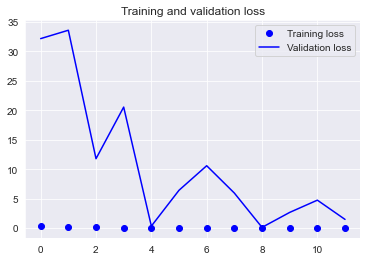

<Figure size 432x288 with 0 Axes>

In [24]:
# Plots

acc = histoire.history['accuracy']
val_acc = histoire.history['val_accuracy']
loss = histoire.history['loss']
val_loss = histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('img/FinalModel.png', bbox_inches = "tight")

This final model shows a very high accuracy score of .91 and a recall score of .86.  These are both very good scores for there respective categories.

### Conclusion

 Our best model was derived iteratively by adding on layers, dropouts, and learning reductions.  The final accuracy score was 91% and the recall score was 86%.  This is a great recall score where only 14% of the misdiagnosed patients were false negatives.  The score could be improved by possibly adding more layers and running a full twenty epochs instead of just 12 and either changing the drop out numbers or adding in a regularizer to deal with overfitting.  This was a much better score than our baseline Logistic Regression that could have further been improved on if we added hyperparameters.  This model will help in conjuction with a doctor solve our business problem, but not be uses on it own as the main diagnostic tool.

### Limitations

1. Medical History
    - No data of medical history was given to possibly allow for preexisting conditions that could increase the probability of pneumonia in patients
2. Fuzzy Scan
    - Some of the scans were fuzzy and hard to interpret which may have cause a lower score during our training and a lower overall score for our model
3. Demographics
    - Very minimal demographics data was included in this data set where only children ages 1-5 and specifically of the Guangzhou Womens Medical Center

### Next Steps

1. Split Viral/Bacterial Pneumonia
    - split the data into viral and bacterial pneumonia time constraints didn't allow us to do this split for our model
2. Demographic data
    - demographic data will allow for more information to be added to our model giving it a better score and allows us to evaluate which demographics are most prone to this disease
3. Medical History
    - Medical History will allow for us to flag patients that are more likely to have pneumonia by showing us preexisting conditions that have a higher change of contracting pneumonia